# 작업해뒀던 데이터셋을 바탕으로 CRNN을 돌렸습니다.

## 라이브러리 불러오기

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path  # 파일 경로를 다루기 위한 클래스
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 데이터셋 불러오기

In [2]:
# 데이터가 있는 디렉토리 경로 설정
data_dir = Path("Dataset_A/")  # 'Path' 클래스를 이용하여 경로 설정

# 모든 이미지의 목록을 가져옴
images = sorted(list(map(str, list(data_dir.glob("*.jpeg")))))
# 이미지 파일 이름에서 레이블(캡챠 텍스트) 추출
labels = [img.split(os.path.sep)[-1].split(".jpeg")[0].split("_")[-1] for img in images]
# 여기서 img.split("_")[-1]은 파일 이름의 마지막 부분(캡챠 문자)을 추출
# 레이블에서 고유한 문자들 추출
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

# 발견된 이미지, 레이블, 고유 문자의 수 출력
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# 학습 및 검증을 위한 배치 크기 설정
batch_size = 16

# 원하는 이미지 크기 설정
img_width = 200
img_height = 50

# 컨볼루션 블록에 의한 이미지 다운샘플링 요소
# 두 개의 컨볼루션 블록을 사용하며 각 블록은 풀링 레이어를 통해 특징을 2배 다운샘플
# 따라서 총 다운샘플링 요소는 4가 됨
downsample_factor = 4

# 데이터셋 내 캡챠의 최대 길이 설정
max_length = max([len(label) for label in labels])


Number of images found:  10001
Number of labels found:  10001
Number of unique characters:  21
Characters present:  ['2', '6', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'x', 'z']


## 데이터셋 전처리

In [3]:
# 문자를 정수로 매핑
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)
# 캡챠에 사용된 각각의 문자에 고유한 정수 ID를 할당

# 정수를 원래의 문자로 매핑
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)
# 매핑된 정수 ID를 다시 원래 문자로 변환

def split_data(images, labels, train_size=0.8, shuffle=True):
    # 1. 데이터셋의 전체 크기를 산출
    size = len(images)

    # 2. 인덱스 배열을 만들고 필요한 경우 섞음
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    # 3. 학습 샘플의 크기 산출
    train_samples = int(size * train_size)

    # 4. 데이터를 학습 및 검증 세트로 분할
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# 데이터를 학습 및 검증 세트로 분할
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    # 이미지를 불러오기
    img = tf.io.read_file(img_path)

    # 이미지를 디코드하고 흑백으로 변환
    img = tf.io.decode_png(img, channels=1)

    # 이미지를 [0, 1] 범위의 float32로 변환
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 원하는 크기로 이미지를 조정
    img = tf.image.resize(img, [img_height, img_width])

    # 시간 차원이 이미지의 너비와 일치하도록 이미지를 전치
    img = tf.transpose(img, perm=[1, 0, 2])

    # 레이블의 문자를 숫자로 매핑
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    # 레이블을 패딩하여 모든 레이블이 동일한 길이를 갖도록 함
    padding_size = max_length - tf.shape(label)[0]
    padding = tf.zeros(padding_size, dtype=label.dtype)  # label과 동일한 타입의 텐서로 패딩 생성
    label = tf.concat([label, padding], axis=0) # 레이블에 패딩 추가

    # 모델이 두 개의 입력을 기대하므로 dict 형태로 반환
    return {"image": img, "label": label}

2023-11-27 20:00:48.630131: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-27 20:00:48.630151: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-27 20:00:48.630157: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-27 20:00:48.630514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 20:00:48.630787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 데이터셋 생성

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# 데이터 시각화

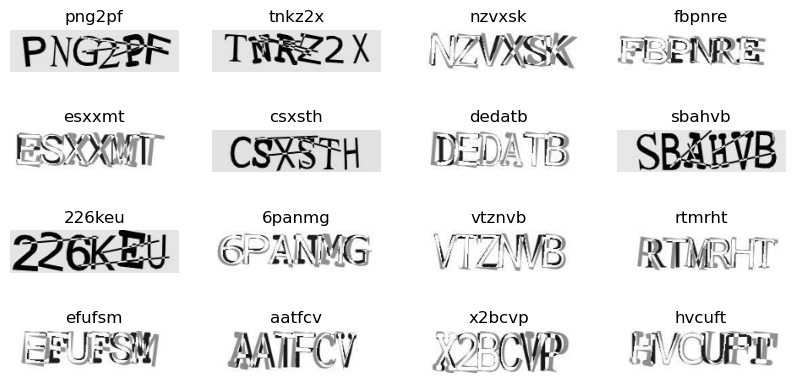

In [5]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## 모델 생성

In [6]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        # CTC 손실 함수 정의

    def call(self, y_true, y_pred):
        # 훈련 시 손실 값을 계산하고 이를 레이어에 추가
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # 테스트 시에는 계산된 예측값을 반환
        return y_pred


def build_model():
    # 모델에 대한 입력 정의
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # 첫 번째 컨볼루션 블록
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 두 번째 컨볼루션 블록
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # 두 개의 풀링 레이어를 사용하므로, 특징 맵은 4배 작아짐
    # 마지막 레이어의 필터 수는 64입니다. RNN 부분으로 넘어가기 전에 적절히 형태를 변경
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN 레이어
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # 출력 레이어
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # 각 단계에서 CTC 손실을 계산하기 위한 CTC 레이어 추가
    output = CTCLayer(name="ctc_loss")(labels, x)

    # 모델 정의
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # 옵티마이저
    opt = keras.optimizers.legacy.Adam()
    # 모델 컴파일 및 반환
    model.compile(optimizer=opt)
    return model


# 모델 생성
model = build_model()
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## 모델 훈련

In [7]:
epochs = 100
early_stopping_patience = 10
# 얼리스탑 추가
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# 모델 훈련하기
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-27 20:01:00.633643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 64s 123ms/step - loss: 20.4507 - val_loss: 19.8751
Epoch 2/100
500/500 [==============================] - 60s 120ms/step - loss: 12.2658 - val_loss: 2.3306
Epoch 3/100
500/500 [==============================] - 60s 120ms/step - loss: 1.5224 - val_loss: 0.7310
Epoch 4/100
500/500 [==============================] - 58s 116ms/step - loss: 0.6637 - val_loss: 0.6102
Epoch 5/100
500/500 [==============================] - 59s 119ms/step - loss: 0.4246 - val_loss: 0.5012
Epoch 6/100
500/500 [==============================] - 57s 115ms/step - loss: 0.3380 - val_loss: 0.5278
Epoch 7/100
500/500 [==============================] - 57s 114ms/step - loss: 0.2550 - val_loss: 0.5393
Epoch 8/100
500/500 [==============================] - 57s 114ms/step - loss: 0.1968 - val_loss: 0.5076
Epoch 9/100
500/500 [==============================] - 70s 139ms/step - loss: 0.1701 - val_loss: 0.4984
Epoch 10/100
500/500 [==============================] - 63s 126ms/step - 

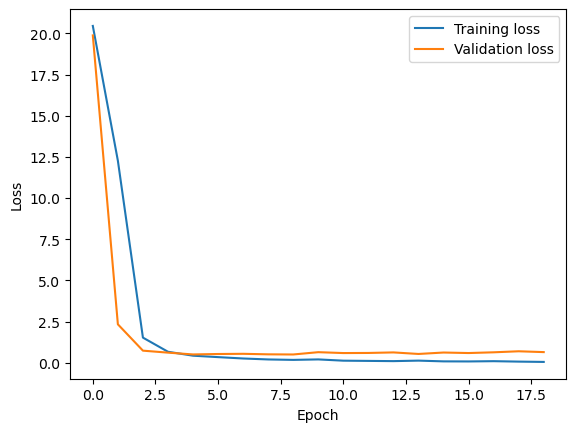

In [8]:
# 훈련 및 검증 손실 그래프
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

## 모델 평가

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

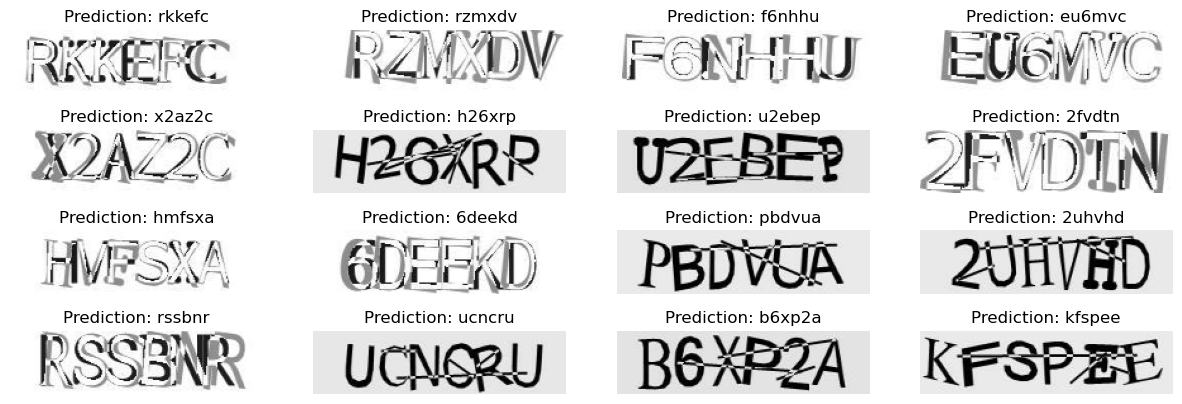

In [9]:
# 출력 레이어까지의 레이어를 추출하여 예측 모델을 구성
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# 네트워크 출력을 디코드하는 유틸리티 함수
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # 탐욕적 검색 사용. 더 복잡한 작업에는 빔 검색 사용 가능
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
              :, :max_length
              ]
    # 결과를 반복하며 텍스트를 추출
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


# 검증 샘플에서 결과 확인
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [58]:
# 모델 저장
model.save('CAPTCHA_CRNN_model(lower).h5')

In [11]:
# 모델 불러오기
model = keras.models.load_model('CAPTCHA_CRNN_model.h5', custom_objects={'CTCLayer': CTCLayer})

In [12]:
# 모델 평가
model.evaluate(validation_dataset)

126/126 [==============================] - 8s 54ms/step - loss: 33.7763


33.77631759643555